In [26]:
import numpy as np
import pandas as pd
from ace_cream import ace_cream
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import datetime
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
from minepy import MINE
from minepy import pstats,cstats
# import pingouin as pg
from rdc import rdc
from statsmodels.tsa.stattools import adfuller,pacf
import statsmodels.tsa.stattools as st
import hyppo
from skfeature.function.information_theoretical_based import JMI,CMIM,MRMR,MIFS,MIM,CIFE
from hyppo.independence import Hsic,CCA
import pandas_datareader.data as web
#Preprocessing and performance evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import log,pi,hypot,fabs,sqrt
import math
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.linear_model import LassoCV
# grid search hyperparameters for ridge regression
from sklearn.model_selection import GridSearchCV

# Model
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression,SGDRegressor,TheilSenRegressor

In [2]:
diamond = pd.read_csv("./dataset/diamond.csv",parse_dates = ['date'],index_col = 'date')

In [3]:
diamond.drop(columns = diamond.columns[0],inplace=True)

In [4]:
diamond.sort_index(ascending=True,inplace=True)

In [5]:
diamond.fillna(method='bfill',inplace=True)

In [6]:
diamond

,diamond price,inflation rate,interest rate,fed rate,gold price
date,,,,,
2018-04-28,10030.58,2.17,0.78,1.70,1322.80
2018-04-29,10032.95,2.17,0.78,1.70,1322.80
2018-04-30,10038.62,2.17,0.78,1.69,1315.38
2018-05-01,10050.07,2.16,0.81,1.70,1300.58
2018-05-02,10047.16,2.17,0.80,1.70,1302.13
...,...,...,...,...,...
2021-05-31,10368.67,2.46,-0.84,0.05,1905.74
2021-06-01,10376.10,2.46,-0.84,0.06,1900.49
2021-06-02,10378.43,2.44,-0.85,0.06,1907.75


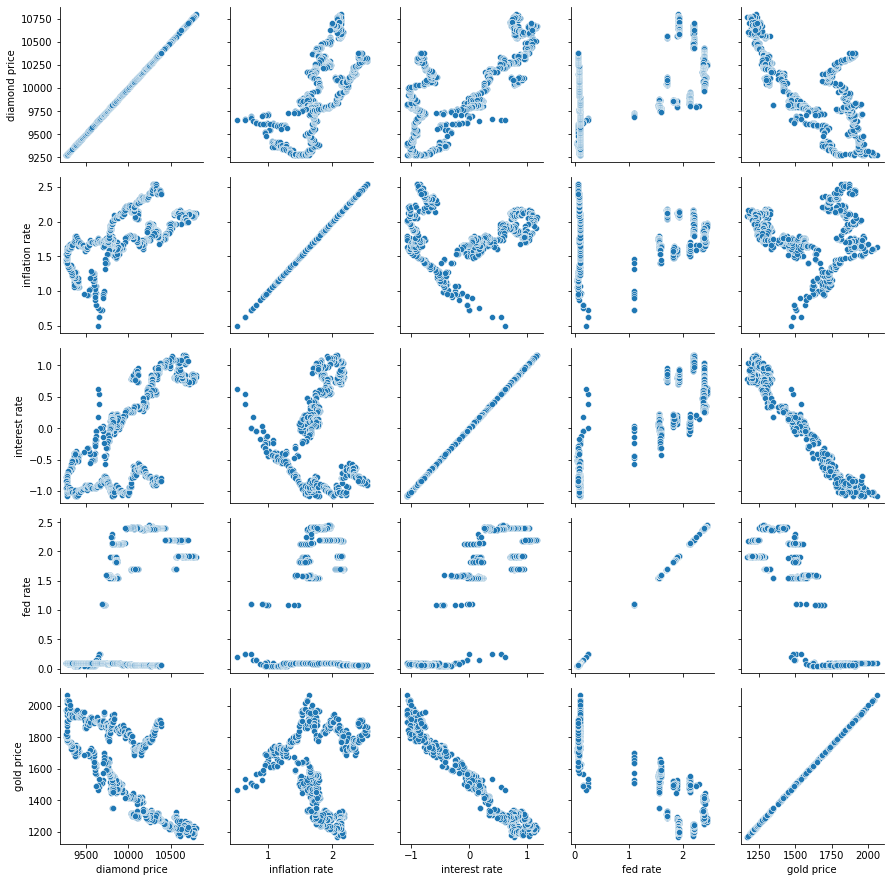

In [127]:
g = sns.PairGrid(diamond)
g.map(sns.scatterplot)

### Preprocessing Step

In [7]:
def segment(data,col_name):
    Y = (data[col_name])
    X = data.drop(col_name,axis=1)
    return X,Y
def Split_Part(data,percent):
    train_len = int(data.shape[0]*percent)
    train_df = data.iloc[:train_len,:]
    test_df = data.iloc[train_len:,:]
    return train_df,test_df

In [8]:
def lag_data(data,max_lag,target):
    X = data.copy()
    X_col = list(X.columns)
    X_col.remove(target)
    for col in X_col:
        for i in range(2,max_lag+1):
            X[col+'_lag_'+str(i)] = X[col].shift(i-1)
    for i in X_col:
        X.rename(columns ={i:i+'_lag_1'},inplace = True)
    X.dropna(inplace = True) 
    return X

In [9]:
df = diamond.copy()

In [10]:
df['diamond price_1'] = df['diamond price'].shift(-1)
df.dropna(inplace=True)

In [11]:
df

,diamond price,inflation rate,interest rate,fed rate,gold price,diamond price_1
date,,,,,,
2018-04-28,10030.58,2.17,0.78,1.70,1322.80,10032.95
2018-04-29,10032.95,2.17,0.78,1.70,1322.80,10038.62
2018-04-30,10038.62,2.17,0.78,1.69,1315.38,10050.07
2018-05-01,10050.07,2.16,0.81,1.70,1300.58,10047.16
2018-05-02,10047.16,2.17,0.80,1.70,1302.13,10046.02
...,...,...,...,...,...,...
2021-05-30,10365.69,2.46,-0.84,0.05,1909.29,10368.67
2021-05-31,10368.67,2.46,-0.84,0.05,1905.74,10376.10
2021-06-01,10376.10,2.46,-0.84,0.06,1900.49,10378.43


In [12]:
train_no,test_no = Split_Part(df,0.7)
x_train_no,y_train_no = segment(train_no,'diamond price_1')
x_test_no,y_test_no = segment(test_no,'diamond price_1')

lag_df = lag_data(df,30,'diamond price_1')
train_df,test_df = Split_Part(lag_df,0.7)
x_train_L,y_train_L = segment(train_df,'diamond price_1')
x_test_L,y_test_L = segment(test_df,'diamond price_1')

In [13]:
total_corr = 0.0
for i in range(train_no.shape[1]):
    for j in range(i+1,train_no.shape[1]):
        total_corr+=stats.pearsonr(train_no.iloc[:,i],train_no.iloc[:,j])[0]
        print(total_corr)

0.8517102393257777
1.7729796106733433
2.485943092727094
1.5318405818853948
2.5307015044811205
3.365979141583349
4.09579861880391
3.2376165859747945
4.091870441456919
4.834005972164718
3.8718150280688577
4.793548964888122
4.018391142253373
4.730587553033772
3.7763693819341024


In [14]:
train_no.shape[1]*(train_no.shape[1]-1)*0.5

15.0

In [15]:
total_corr/=train_no.shape[1]*(train_no.shape[1]-1)*0.5

In [16]:
total_corr

0.2517579587956068

In [17]:
def Stacking_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    #Split Data
#     X_train,X_test,Y_train,Y_test = split_data(x_scaled,y_scaled,percent)
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    #LInear Regression
    reg_Linear =  LinearRegression()
    reg_Linear.fit(x_train,y_train.reshape(-1,))
    y_Linear_a = reg_Linear.predict(x_test)
    y_Linear_a_inverse =minmax_y_test.inverse_transform(y_Linear_a.reshape((-1,1)))
    
    #RandomForestRegressor
    reg_rfr = RandomForestRegressor()
    reg_rfr.fit(x_train,y_train.reshape(-1,))
    y_rfr = reg_rfr.predict(x_test)
    y_rfr_inverse = minmax_y_test.inverse_transform(y_rfr.reshape((-1,1))).reshape(-1,)

    
    fig,ax = plt.subplots(2,1,figsize=(20,12))
    ax[0].plot(y_Linear_a_inverse,label='Linear')
    ax[0].plot(y_test_inverse ,label='Actual')
    ax[0].legend()
    ax[1].plot(y_rfr_inverse,label='RandomForestRegressor')
    ax[1].plot(y_test_inverse ,label='Actual')
    ax[1].legend()

    
    print("Linear_r2:%f"%(r2_score(y_Linear_a_inverse, y_test_inverse  ))+"\n",
      "Linear_rmse:%f"%(sqrt(mean_squared_error(y_Linear_a_inverse, y_test_inverse )))+"\n",
      "Linear_mse:%f"%(mean_squared_error(y_Linear_a_inverse, y_test_inverse  ))+"\n",
          "RandomForestRegressor_r2:%f"%(r2_score(y_rfr_inverse, y_test_inverse  ))+"\n",
          "RandomForestRegressor_rmse:%f"%(sqrt(mean_squared_error(y_rfr_inverse, y_test_inverse  )))+"\n",
          "RandomForestRegressor_mse:%f"%(mean_squared_error( y_rfr_inverse, y_test_inverse  ))
     )
    
    y_df = {
        "Original": y_test_inverse  ,
        "Linear":y_Linear_a_inverse,
        "RandomForestRegressor":y_rfr_inverse,
    }
    
    RMSE_dict = {
        "Linear":sqrt(mean_squared_error(y_Linear_a_inverse,y_test_inverse)),
        "RandomForestRegressor":sqrt(mean_squared_error(y_rfr_inverse, y_test_inverse )),
    }
    
    return y_df,RMSE_dict

Linear_r2:0.999378
 Linear_rmse:8.549375
 Linear_mse:73.091808
 RandomForestRegressor_r2:0.984575
 RandomForestRegressor_rmse:39.276131
 RandomForestRegressor_mse:1542.614454


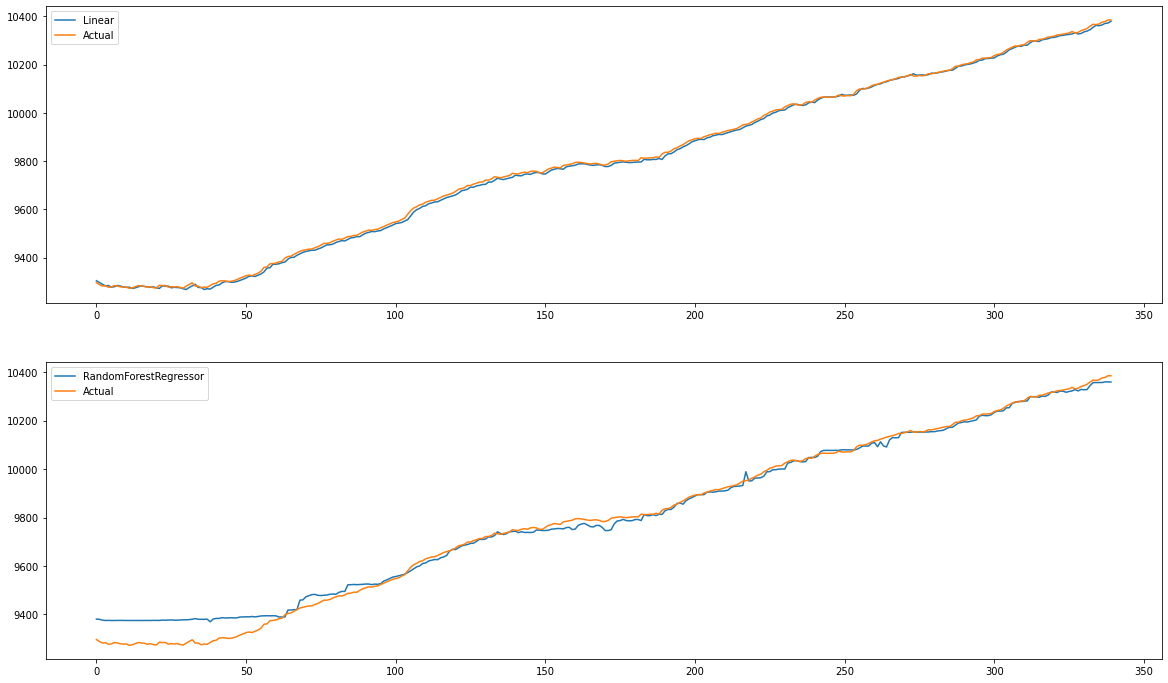

In [18]:
y_pred_no,rmse_no = Stacking_Regressor(x_train_no,y_train_no,x_test_no,y_test_no)

Linear_r2:0.997021
 Linear_rmse:18.454208
 Linear_mse:340.557803
 RandomForestRegressor_r2:0.674294
 RandomForestRegressor_rmse:155.234669
 RandomForestRegressor_mse:24097.802560


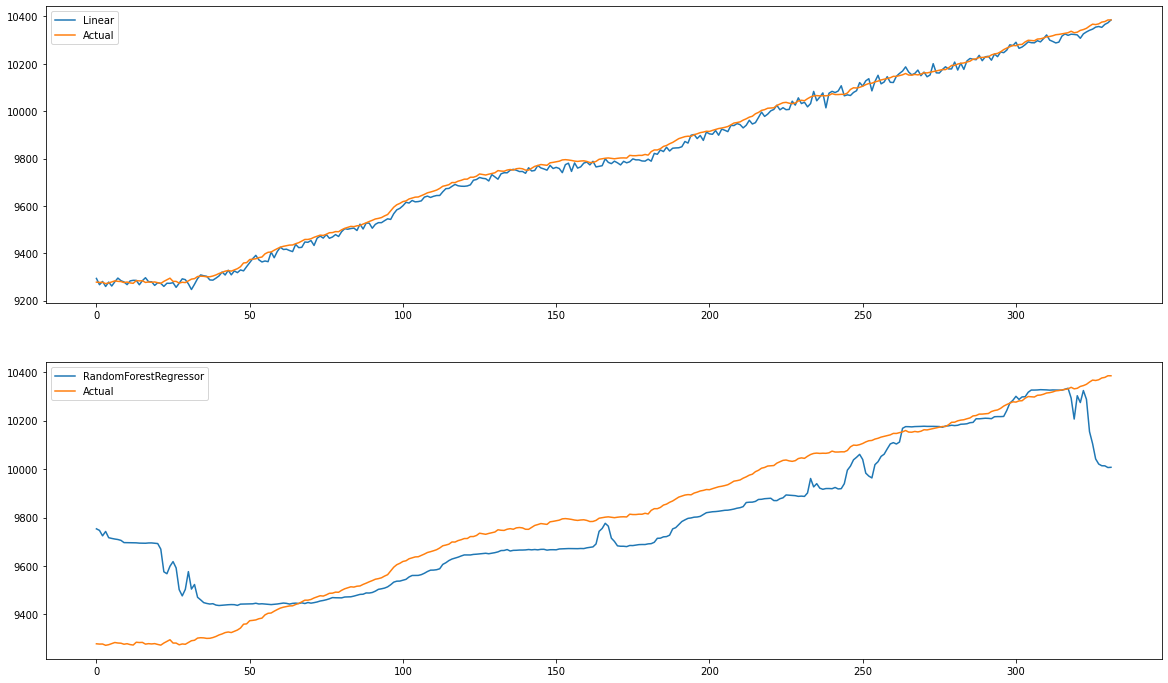

In [19]:
y_pred_all,rmse_all = Stacking_Regressor(x_train_L,y_train_L,x_test_L,y_test_L)

### PACF

In [20]:
def lag_based_PACF(data,max_lag,width):
    lags_pacf,interval = st.pacf(data,max_lag,"yw",width)
    lags = []
    boundary = (interval[:,1] - lags_pacf)[1]
    lags_pacf = np.abs(lags_pacf)
    for idx,lag in enumerate(lags_pacf):
        if lag > boundary:
            lags.append(idx)
    return lags

In [21]:
def parser(s):
    return datetime.strptime(s,'%Y-%m-%d')

def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:%f, p-value:%f'%(result[0],result[1]))

In [148]:
for col in list(df.columns):
    print(" ADF test of %s,diff_1_%s, diff_2%s "%(col,col,col))
    perform_adf_test(df[col])
    perform_adf_test(df[col].diff(1).dropna())
    perform_adf_test(df[col].diff(2).dropna())

 ADF test of diamond price,diff_1_diamond price, diff_2diamond price 
ADF Statistic:-0.480667, p-value:0.895734
ADF Statistic:-30.049596, p-value:0.000000
ADF Statistic:-4.540736, p-value:0.000166
 ADF test of inflation rate,diff_1_inflation rate, diff_2inflation rate 
ADF Statistic:-1.429153, p-value:0.568223
ADF Statistic:-6.572666, p-value:0.000000
ADF Statistic:-6.952391, p-value:0.000000
 ADF test of interest rate,diff_1_interest rate, diff_2interest rate 
ADF Statistic:-0.661207, p-value:0.856544
ADF Statistic:-10.872212, p-value:0.000000
ADF Statistic:-8.382523, p-value:0.000000
 ADF test of fed rate,diff_1_fed rate, diff_2fed rate 
ADF Statistic:-0.500787, p-value:0.891863
ADF Statistic:-6.928416, p-value:0.000000
ADF Statistic:-6.364184, p-value:0.000000
 ADF test of gold price,diff_1_gold price, diff_2gold price 
ADF Statistic:-0.299080, p-value:0.925634
ADF Statistic:-12.308168, p-value:0.000000
ADF Statistic:-7.395661, p-value:0.000000
 ADF test of diamond price_1,diff_1_di

In [24]:
df_diff = df.diff(1).dropna()

train_diff_df,test_diff_df = Split_Part(df_diff,0.7)
x_train_diff,y_train_diff = segment(train_diff_df,'diamond price_1')
x_test_diff,y_test_diff = segment(test_diff_df,'diamond price_1')

In [25]:
lags_pool = {}
for col in x_train_diff.columns:
    lags_pool[col] = lag_based_PACF(x_train_diff[col],29,0.05)

In [26]:
pacf_cols = []
for k,v in lags_pool.items():
    for i in v:
        pacf_cols.append(k+'_lag_'+str(i+1))

In [33]:
len(pacf_cols)

34

Linear_r2:0.998001
 Linear_rmse:15.100558
 Linear_mse:228.026844
 RandomForestRegressor_r2:0.810433
 RandomForestRegressor_rmse:122.829746
 RandomForestRegressor_mse:15087.146595


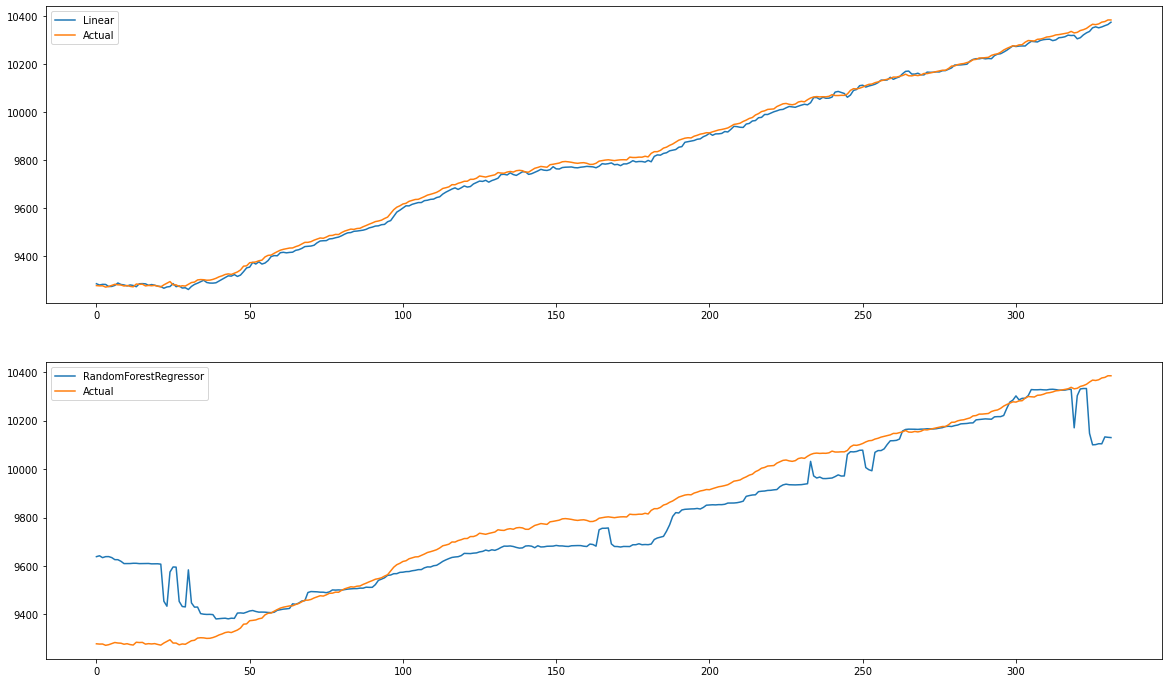

In [155]:
pacf_collection = Stacking_Regressor(x_train_L[pacf_cols],y_train_L,x_test_L[pacf_cols],y_test_L)

### Change Train Data and Test Data into numpy array

In [27]:
X_arr = x_train_L.values
Y_arr = y_train_L.values

In [23]:
x_train_L.columns

Index(['diamond price_lag_1', 'inflation rate_lag_1', 'interest rate_lag_1',
       'fed rate_lag_1', 'gold price_lag_1', 'diamond price_lag_2',
       'diamond price_lag_3', 'diamond price_lag_4', 'diamond price_lag_5',
       'diamond price_lag_6',
       ...
       'gold price_lag_21', 'gold price_lag_22', 'gold price_lag_23',
       'gold price_lag_24', 'gold price_lag_25', 'gold price_lag_26',
       'gold price_lag_27', 'gold price_lag_28', 'gold price_lag_29',
       'gold price_lag_30'],
      dtype='object', length=150)

### MI

In [24]:
mi_xy = mutual_info_regression(X_arr,Y_arr)

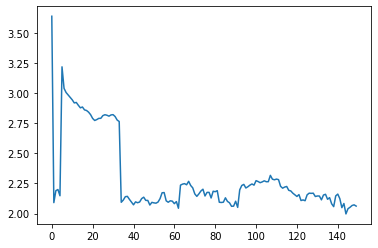

In [30]:
plt.plot(mi_xy)

In [103]:
X_arr[:,0].shape

(772,)

In [25]:
mi_xx = np.zeros([x_train_L.shape[1],x_train_L.shape[1]])
for i in range(mi_xx.shape[0]):
    for j in range(mi_xx.shape[1]):
        mi_xx[i][j] = mutual_info_regression(X_arr[:,0].reshape(-1,1),Y_arr)
    print(i+1,'/',mi_xx.shape[1],end='\r',flush=True)

In [28]:
mi_xx

array([[3.63885937, 3.63817413, 3.63807158, ..., 3.63986685, 3.63877759,
        3.63897832],
       [3.63839983, 3.63925337, 3.6388218 , ..., 3.63844121, 3.6388272 ,
        3.63820009],
       [3.63847458, 3.63905825, 3.63859049, ..., 3.63854093, 3.6391814 ,
        3.63847899],
       ...,
       [3.63816411, 3.63956384, 3.63830803, ..., 3.63819469, 3.6386571 ,
        3.6383746 ],
       [3.63848254, 3.63855096, 3.63852834, ..., 3.63942526, 3.63855096,
        3.63910682],
       [3.63954863, 3.63855096, 3.63822271, ..., 3.63907526, 3.63883161,
        3.63893514]])

### MIC

In [30]:
mic_xy = cstats(X_arr.T,Y_arr.T.reshape(1,-1),est="mic_approx")[0]

In [31]:
len(mic_xy)

150

In [252]:
mic_xx = np.zeros([x_train_L.shape[1],x_train_L.shape[1]])
X_arr_T = X_arr.T
for i in range(mic_xx.shape[1]):
    %time mic_xx[i] = cstats(X_arr_T[i,:].reshape(1,-1),X_arr_T)[0]
    print(i,'/',mic_xx.shape[1],end = "\r",flush=True)

Wall time: 3.14 s
Wall time: 2.78 s
Wall time: 3.06 s
Wall time: 2.27 s
Wall time: 3.83 s
Wall time: 3.01 s
Wall time: 3.49 s
Wall time: 3.26 s
Wall time: 3.09 s
Wall time: 3.15 s
Wall time: 3.74 s
Wall time: 3.63 s
Wall time: 3.38 s
Wall time: 3.68 s
Wall time: 3.52 s
Wall time: 3.33 s
Wall time: 3.31 s
Wall time: 3.37 s
Wall time: 3.19 s
Wall time: 3.36 s
Wall time: 3.17 s
Wall time: 3.19 s
Wall time: 3.4 s
Wall time: 3.16 s
Wall time: 3.21 s
Wall time: 3.3 s
Wall time: 3.53 s
Wall time: 3.3 s
Wall time: 3.69 s
Wall time: 3.32 s
Wall time: 3.36 s
Wall time: 3.52 s
Wall time: 3.34 s
Wall time: 3.29 s
Wall time: 3.34 s
Wall time: 4.34 s
Wall time: 3.42 s
Wall time: 3.25 s
Wall time: 3.15 s
Wall time: 3.03 s
Wall time: 3.88 s
Wall time: 4.24 s
Wall time: 4.83 s
Wall time: 4.19 s
Wall time: 4.37 s
Wall time: 4.73 s
Wall time: 3.12 s
Wall time: 2.93 s
Wall time: 3 s
Wall time: 2.93 s
Wall time: 2.92 s
Wall time: 2.92 s
Wall time: 2.95 s
Wall time: 2.94 s
Wall time: 3.12 s
Wall time: 2.91 

## CCF

In [33]:
ccf_xy ={} 
for i in x_train_no.columns:
    ccf_xy[i] = st.ccf(x_train_no[i],y_train_no,adjusted = False)[:30]
ccf_xy_flat =[]
for v in ccf_xy.values():
    for i in v:
        ccf_xy_flat.append(i)
ccf_xy_flat = np.abs(ccf_xy_flat)

In [34]:
%%time
ccf_xx = np.zeros([x_train_L.shape[1],x_train_L.shape[1]])

for i in range(ccf_xx.shape[1]):
    for j in range(ccf_xx.shape[1]):
        ccf_xx[i][j] = st.ccf(X_arr[:,i],X_arr[:,j])[0]
    print(i+1,'/',ccf_xx.shape[1],end='\r',flush=True)

Wall time: 11.4 s150 150 150 150 150 / 150 / 150


In [45]:
ccf_xx = np.abs(ccf_xx)

### Pearson

In [35]:
pearson_xx = np.zeros([x_train_L.shape[1],x_train_L.shape[1]])

for i in range(x_train_L.shape[1]):
    for j in range(x_train_L.shape[1]):
        pearson_xx[i][j] = stats.pearsonr(X_arr[:,i],X_arr[:,j])[0]

In [46]:
pearson_xx = np.abs(pearson_xx)

In [212]:
def mRMR(selected,idx,metric_xy,metric_xx):
    
    mrmr = 0.0
    
    if len(selected) == 0:
        mrmr = metric_xy[idx]
        
    else:
        col_len = len(selected)
        relevance_score = 0
        redundency_score = 0
        relevance_score = metric_xy[idx] 
#         redundency_score = sum([metric_xx[idx][i] for i in selected])/(col_len)
        X_s = selected+[idx]
#         col_len = len(X_s)
        
#         for i in selected+[idx]:
#             relevance_score+=metric_xy[i]
#         relevance_score/=(col_len)

        for i in range(col_len-1):
            for j in range(i+1,col_len):
                redundency_score+=metric_xx[X_s[i]][X_s[j]]
        redundency_score/=(col_len)

        mrmr = relevance_score - redundency_score

    return mrmr

In [247]:
def incremental_selection(x,metric):
    X = np.array(x)
    selected = [] # indices of selected fetures
    rest = list(range(X.shape[1]))
    prev_score = 0
    metric_xy = []
    metric_xx = []
    # stop = False
    max_score = 0
    if metric == 'MI-MI':
        metric_xy = mi_xy
        metric_xx = mi_xx
    if metric =='MI-MI-Norm':
        metric_xy = mi_xy_norm 
        metric_xx = mi_norm
    elif metric == 'MI-Pearson':
        metric_xy = mi_xy_norm 
        metric_xx = pearson_norm
    elif metric == 'MI-MIC':
        metric_xy = mi_xy
        metric_xx = mic_xx
    elif metric == 'MI-CCF':
        metric_xy = mi_xy_norm 
        metric_xx = ccf_norm    
    elif metric == 'MIC-MI':
        metric_xy = mic_xy_norm
        metric_xx = mi_norm
    elif metric == 'MIC-CCF':
        metric_xy = mic_xy_norm 
        metric_xx = ccf_norm 
    elif metric == 'MIC-MIC':
        metric_xy = mic_xy
        metric_xx = mic_xx
    elif metric == 'MIC-Pearson':
        metric_xy = mic_xy_norm
        metric_xx = pearson_norm
    elif metric == 'CCF-Pearson':
        metric_xy = ccf_xy_norm
        metric_xx = pearson_norm
    
    while len(rest)>0:
        id_max = rest[0]
        max_score = 0   
        for idx in rest:
            temp_score = mRMR(selected,idx,metric_xy,metric_xx)
            if temp_score>max_score:
                id_max = idx
                max_score = temp_score
#         id_max = rest[np.argmax(temp)]
#         max_score = max(temp)
#         scores.append(max_score)
#         print("max_score")
        if max_score <=0:        
             return selected
             break                
        selected = selected + [id_max]
        rest.remove(id_max)
        print(f"selected:{selected},delta_score:{max_score}",end = "\r",flush=True)
    
    return selected

In [248]:
metric_list = ['MI-MI','MI-Pearson','MI-CCF','MIC-CCF','MIC-Pearson','CCF-Pearson','MIC-MI']

In [249]:
features_dict = {}
for m in metric_list:
    print(m,'\n')
    features_dict[m] = incremental_selection(x_train_L,m)

MI-MI 

MI-Pearson , 5, 6],delta_score:1.2199504838236206

MI-CCF d:[0, 5, 6, 7],delta_score:0.0012173825193674366

MIC-CCF :[0, 5, 6, 7],delta_score:0.0012173825193674348

MIC-Pearson 9, 128, 127, 126, 125],delta_score:[0.00208757]

CCF-Pearson 9, 128, 127, 126, 125],delta_score:[0.00208757]

MIC-MI d:[0, 1, 2, 3],delta_score:0.0010426113676067893



In [250]:
for k,v in features_dict.items():
    print(k,len(v))

MI-MI 3
MI-Pearson 4
MI-CCF 4
MIC-CCF 5
MIC-Pearson 5
CCF-Pearson 4
MIC-MI 5


MI-MI
Linear_r2:0.999707
 Linear_rmse:5.761543
 Linear_mse:33.195376
 RandomForestRegressor_r2:0.997703
 RandomForestRegressor_rmse:16.254297
 RandomForestRegressor_mse:264.202174
MI-Pearson
Linear_r2:0.999709
 Linear_rmse:5.747460
 Linear_mse:33.033295
 RandomForestRegressor_r2:0.997004
 RandomForestRegressor_rmse:18.619962
 RandomForestRegressor_mse:346.702996
MI-CCF
Linear_r2:0.999709
 Linear_rmse:5.747460
 Linear_mse:33.033295
 RandomForestRegressor_r2:0.997306
 RandomForestRegressor_rmse:17.660955
 RandomForestRegressor_mse:311.909325
MIC-CCF
Linear_r2:-0.556145
 Linear_rmse:262.473073
 Linear_mse:68892.113833
 RandomForestRegressor_r2:-0.618446
 RandomForestRegressor_rmse:273.994577
 RandomForestRegressor_mse:75073.028085
MIC-Pearson
Linear_r2:-0.556145
 Linear_rmse:262.473073
 Linear_mse:68892.113833
 RandomForestRegressor_r2:-0.611853
 RandomForestRegressor_rmse:274.269971
 RandomForestRegressor_mse:75224.017141
CCF-Pearson
Linear_r2:0.998380
 Linear_rmse:13.672928
 Linear_mse:

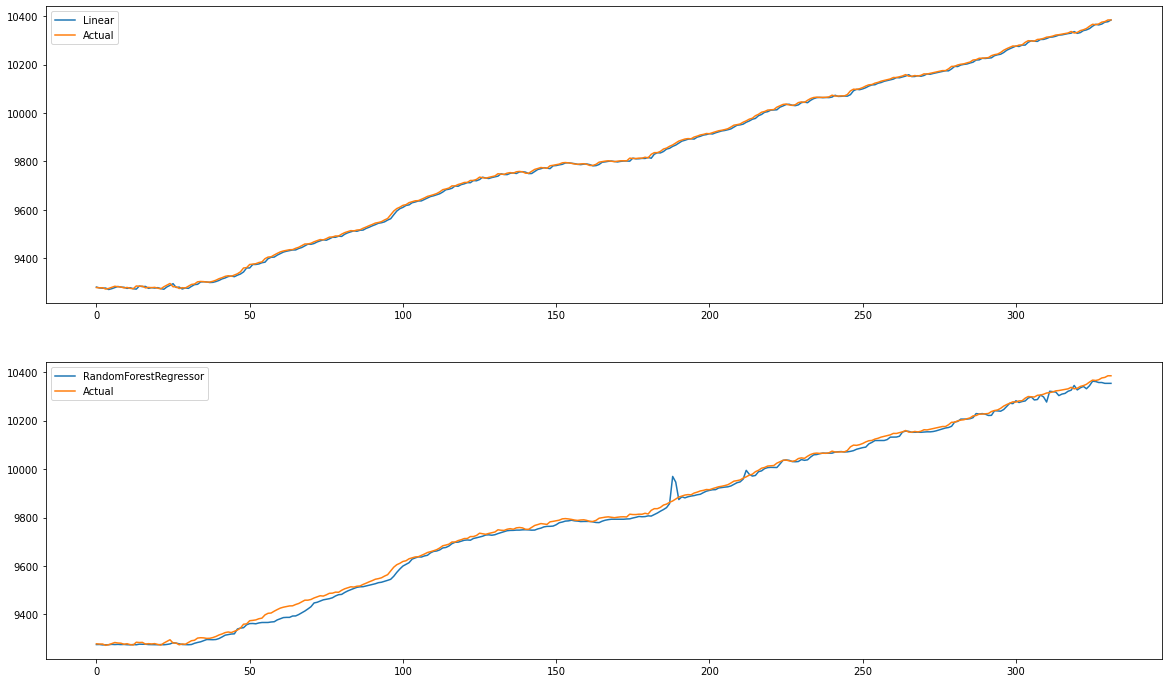

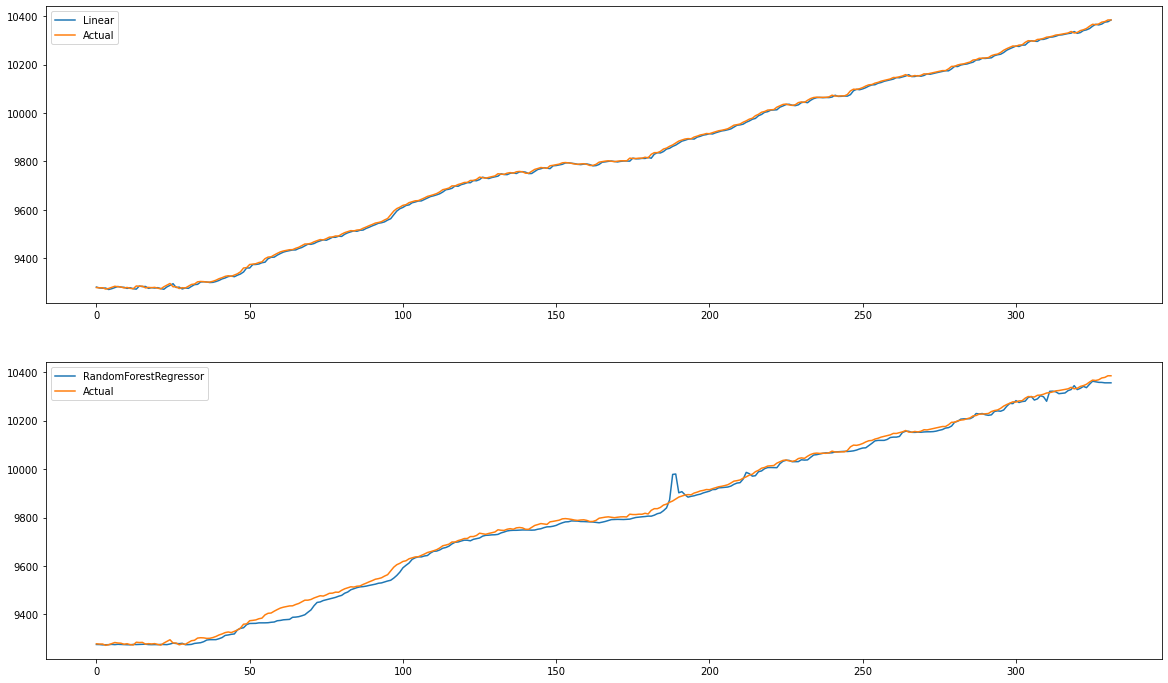

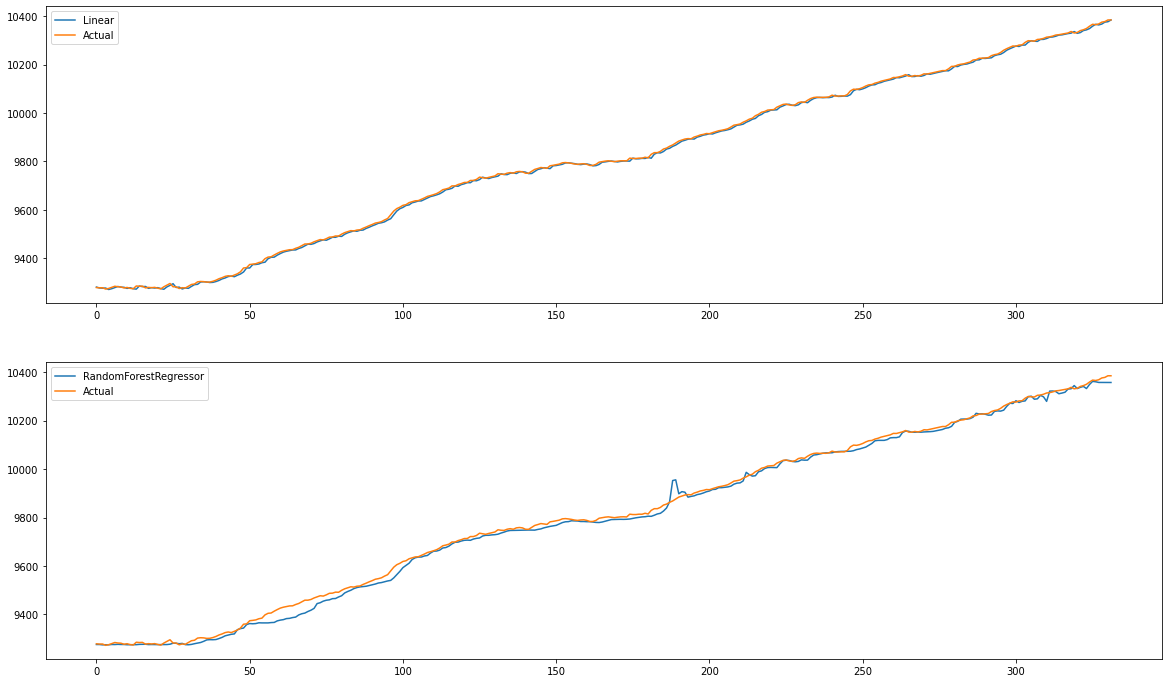

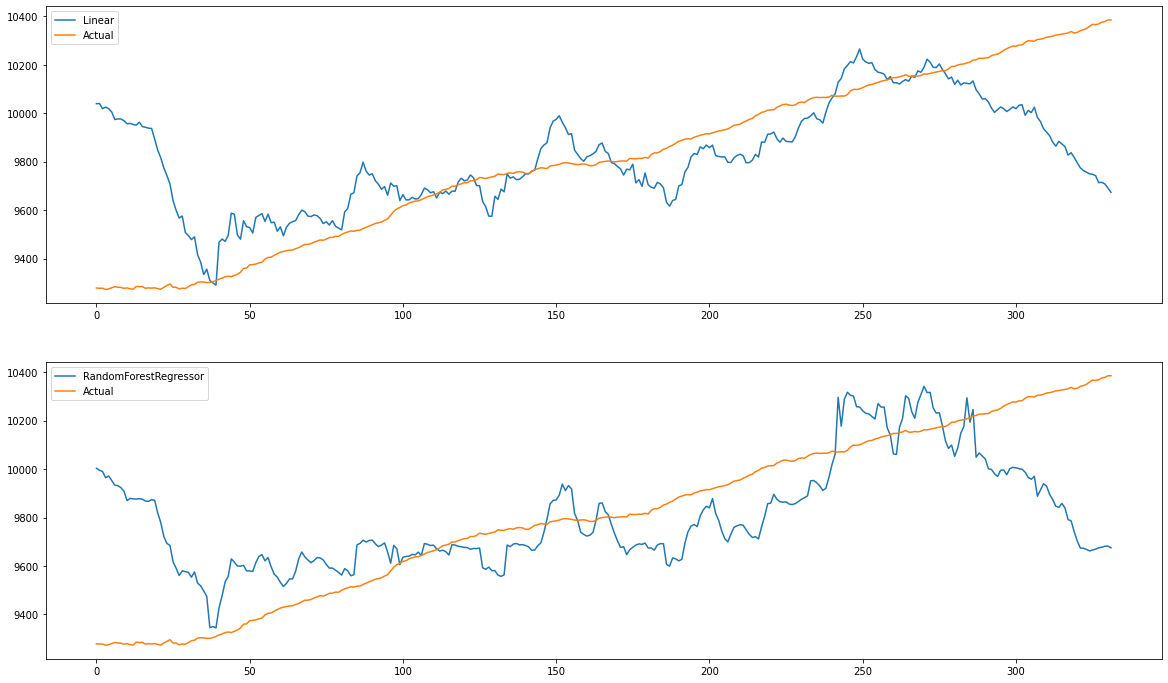

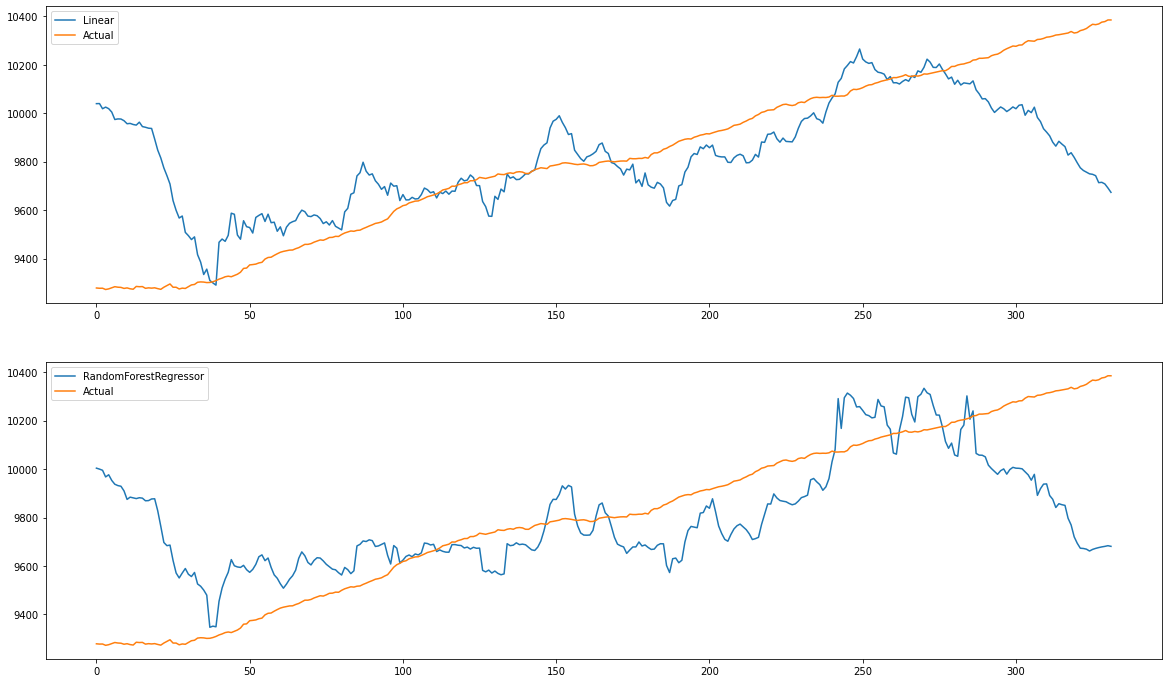

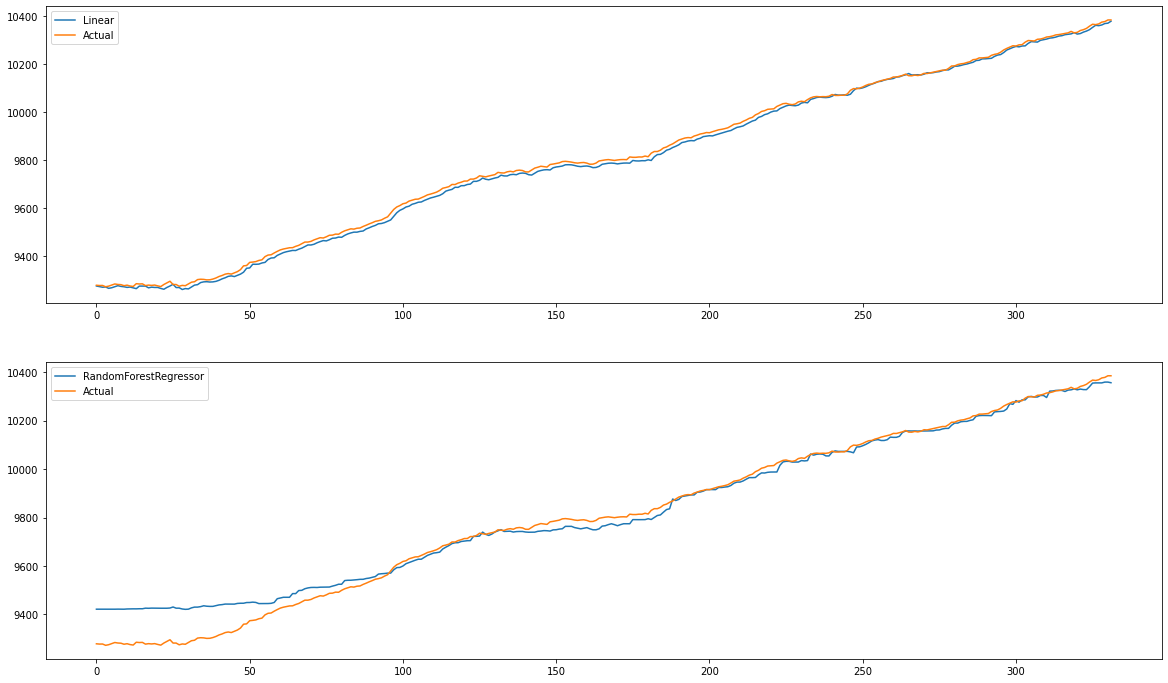

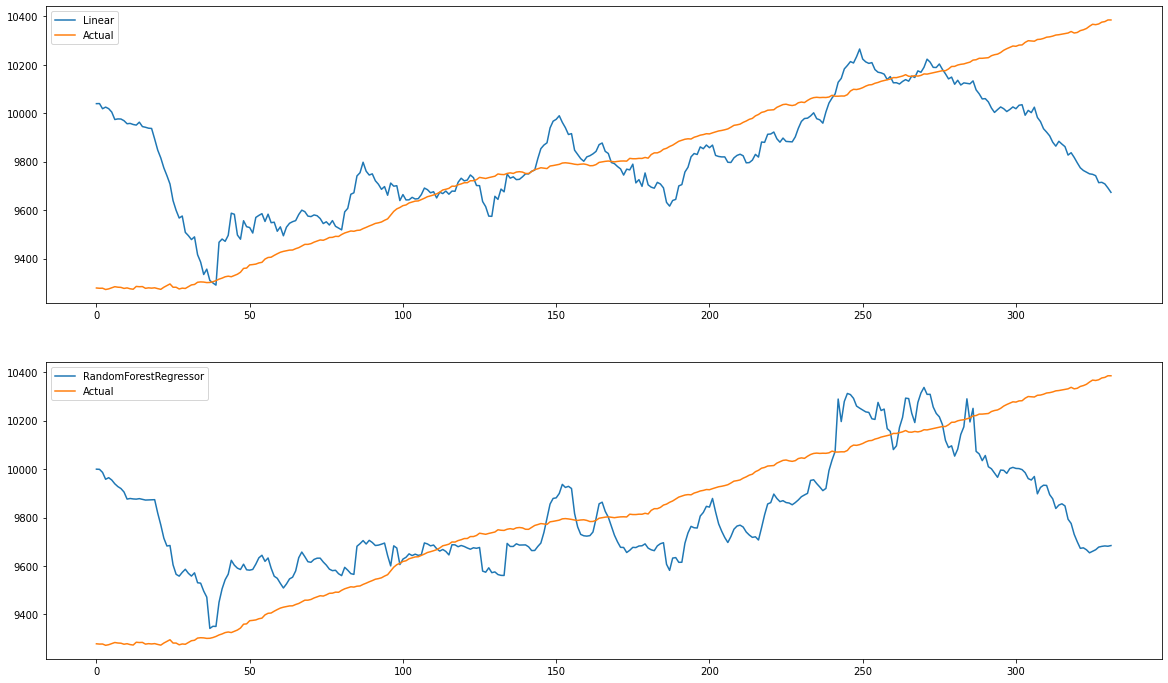

In [251]:
result = []
for i in metric_list:
    cols = x_train_L.columns[features_dict[i]]
    print(i)
    result.append(Stacking_Regressor(x_train_L[cols],y_train_L,x_test_L[cols],y_test_L))

In [187]:
ccf_xy_norm = (ccf_xy_flat/sum(ccf_xy_flat))

In [234]:
mic_xy_norm = (mic_xy/sum(mic_xy))

In [160]:
mi_xy_norm = (mi_xy/sum(mi_xy))`

In [151]:
mi_norm = mi_xx.copy()

for i in range(mi_norm.shape[1]):
    mi_norm[i,:]/=sum(mi_norm[i,:])

In [241]:
ccf_norm = ccf_xx.copy()

for i in range(ccf_norm.shape[1]):
    ccf_norm[i,:]/=sum(ccf_norm[i,:])

In [236]:
pearson_norm = pearson_xx.copy()

for i in range(pearson_norm.shape[1]):
    pearson_norm[i,:]/=sum(pearson_norm[i,:])

In [246]:
max(mic_xy_norm)

array([0.0134216])

In [242]:
ccf_norm

array([[0.0074966 , 0.00659988, 0.00705422, ..., 0.00706392, 0.00705485,
        0.00704545],
       [0.00709598, 0.0080601 , 0.00666842, ..., 0.00685453, 0.00682529,
        0.0067976 ],
       [0.00706763, 0.00621401, 0.00751085, ..., 0.00705003, 0.0070553 ,
        0.00706143],
       ...,
       [0.00696839, 0.00628909, 0.00694149, ..., 0.00739522, 0.00735458,
        0.00732338],
       [0.00696312, 0.00626558, 0.00695035, ..., 0.00735847, 0.00739913,
        0.00735831],
       [0.00695781, 0.00624371, 0.00696036, ..., 0.00733142, 0.00736251,
        0.00740334]])